# Week 04 Lab: Generating Molecular Conformations

## Student Name: YOUR NAME HERE

## Generating molecular conformations with machine learning

In this lab we will build a generative model (based on neural networks) that learns how to generate molecular conformations.

We will work with the MD simulation data for the "alanine dipeptide" molecule. This simple molecule is frequently used as a system to develop and benchmark new methods for the analysis and modeling of molecular dynamics data. An example conformation is shown below:

<img alt="Alanine dipeptide" src="https://raw.githubusercontent.com/ADicksonLab/ml4md-jb/main/Week-04/alanine_dipeptide.png" width="350px"/>

Note: the molecule is an alanine capped with an acetyl group at the N-terminus and N-methylamide at the C-terminus.

## Downloading data

We will first download a set of conformations for the alanine dipeptide.

The data is freely available at the [mdshare repository](https://markovmodel.github.io/mdshare/ALA2/) (from the  [Computational Molecular Biology Group, Freie Universität Berlin](http://www.mi.fu-berlin.de/en/math/groups/comp-mol-bio/index.html)) and is licensed under [CC BY 4.0](http://creativecommons.org/licenses/by/4.0/).

You can download it from your browser here:
* MD data: [alanine-dipeptide-3x250ns-heavy-atom-positions.npz](http://ftp.imp.fu-berlin.de/pub/cmb-data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz)
* Topology file: [alanine-dipeptide-nowater.pdb](http://ftp.imp.fu-berlin.de/pub/cmb-data/alanine-dipeptide-nowater.pdb)

Instead of downloading it via the browswer, you can use `wget` in the cell below. That may be convenient when using Google Colab.

In [ ]:
# !wget -nc http://ftp.imp.fu-berlin.de/pub/cmb-data/alanine-dipeptide-nowater.pdb
# !wget -nc http://ftp.imp.fu-berlin.de/pub/cmb-data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz

## Initialize our environment

Let's import all the libraries that we will need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import mdtraj
try:
    import nglview as nv
    from nglview import NGLWidget
    has_nglview = True
except ImportError:
    print("- Could not import nglview.")
    has_nglview = False
    
import torch
import torch.nn as nn
import torch.optim as optim

Decide which device we want to run on pytorch (which we will use to implement neural networks)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("- Using device '%s'" % device)

- Using device 'cpu'


## Prepare data

### Load xyz data

We will work with xyz coordinates of heavy atoms stored in the `alanine-dipeptide-3x250ns-heavy-atom-positions.npz` file.

This file stores x, y and z coordinates of three MD trajectories as numpy arrays of shape `(T, N*3)`, where `T` is the number of frames (that is, conformations), `N` is the number of atoms in the system and `3` is for the cartesian coordinates of each atom.

In [3]:
data_filepath = "alanine-dipeptide-3x250ns-heavy-atom-positions.npz"

# We want to collect our the frames in this variable.
all_xyz = []

# Load the data.
data = np.load(data_filepath)
for key in data:
    # Each key is used to store an array.
    print("- Trajectory with key %s has shape: %s" % (key, repr(data[key].shape)))
    all_xyz.append(data[key])
# Concatenate the arrays.
all_xyz = np.concatenate(all_xyz)
print("- All frames are concatenated in an array with shape:", all_xyz.shape)

- Trajectory with key arr_0 has shape: (250000, 30)
- Trajectory with key arr_1 has shape: (250000, 30)
- Trajectory with key arr_2 has shape: (250000, 30)
- All frames are concatenated in an array with shape: (750000, 30)


### Reshape arrays

For analysis purposes, we will reshape the arrays that store our MD data.

We start with `(T, N*3)` arrays and want to reshape them to `(T, N, 3)`.

Insert in the cell below the number of atoms that we have in our system.

In [12]:
n_atoms = int(all_xyz.shape[1]/3)

In [13]:
number_of_frames = all_xyz.shape[0]

Now reshape the array with our data. You can use the numpy `reshape` method for arrays.
See https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html

In [14]:
all_xyz = all_xyz.reshape((number_of_frames,n_atoms,3))  # Your code here.
print("- Final xyz array shape:", all_xyz.shape)

- Final xyz array shape: (750000, 10, 3)


### Select a random portion of the whole MD data

We actually have a lot of MD frames for this simple system (750 ns of MD data). We can assume that the conformational space of this molecule was sampled exhaustively in these simulations. 

For our purposes today, we will need only a small portion of these frames. Training a generative model with all of the data could take too much time.

Let's randomly select only a certain random of frames, these are the ones that we will use!

In [15]:
number_of_random_frames = 50000  # You can increase or decrease this number to see how
                                 # it will affect our generative modeling study.

First select some random ids. We first the `numpy.random.choice` function (https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) to generate some random ids. Then we select from our original array the frames corresponding to those ids.

In [16]:
random_ids = np.random.choice(all_xyz.shape[0], number_of_random_frames, replace=False)
all_xyz = all_xyz[random_ids]

print("- Now our MD data has shape:", all_xyz.shape)

- Now our MD data has shape: (50000, 10, 3)


### Use mdtraj for the analysis and modification of our MD data

`mdtraj` has a lot of extremely useful functionalities, we will use some of them.

First of all, we will initialize a `Topology` object for the heavy-atom representation of our molecule. The details in this cell are not important for today's lecture, so feel free to just run the code.

In [17]:
topology_filepath = "alanine-dipeptide-nowater.pdb"
allatom_topology = mdtraj.load(topology_filepath).topology
heavyatom_topology = allatom_topology.subset(allatom_topology.select("element != H"))
heavyatom_topology

<mdtraj.Topology with 1 chains, 3 residues, 10 atoms, 9 bonds at 0x7fb30d58bdf0>

Then we will create a `Trajectory` object for our MD data.

In [18]:
m_traj = mdtraj.Trajectory(xyz=all_xyz,
                           topology=heavyatom_topology)

Let's take a look at the conformations in our MD data by using `nglview` (if installed).

Please note that we randomly selected our MD frames, so the frames in the trajectory will not be in "chronological" order.

In [19]:
if has_nglview:
    m_view = nv.show_mdtraj(m_traj)
    m_view.center()
else:
    m_view = None
m_view

NGLWidget(max_frame=49999)

The conformations seem to be somewhat centered. That's lucky! Our generative model will generate xyz coordinates. We will use neural networks that are NOT SE(3) invariant. This means that rotating or translating the conformations could drastically alter the way our networks see the conformations.

Since our conformations are centered, we will not need to alter their coordinates. In general, you might want to center your data on some reference conformation if you want to train a machine learning model.

We will discuss experiments to see what happens to our generative model if the conformations are not centered.

The best way to represent 3D conformation in machine learning is still an open problem.

### Analyze distance distributions.

In order to check if our generative model is doing a good job at approximating the distribution of conformations in our MD data, we will consider interatomic distances. Right now, we only have xyz coordinates for our MD data, so we will need to compute the corresponding distance matrix data. 

First, let's print the atoms names and their indices. This will be useful when we will start looking at interatomic distance distributions.

In [20]:
print("- Atom indices")
for i, atom_i in enumerate(m_traj.topology.atoms):
    print(i, atom_i)

- Atom indices
0 ACE1-CH3
1 ACE1-C
2 ACE1-O
3 ALA2-N
4 ALA2-CA
5 ALA2-CB
6 ALA2-C
7 ALA2-O
8 NME3-N
9 NME3-C


Here we will compute the distance map. We define a function that we will also use later.

In [21]:
def convert_xyz_to_dmap(xyz):
    """
    Gets as input a xyz array of shape (T, N, 3), where T is the number of frames and
    N is the number of atoms.
    Computes the distance matrix for each conformation and returns an new array of
    shape (T, N, N).
    """
    return np.sqrt(np.sum(np.square(xyz[:,None,:,:] - xyz[:,:,None,:]), axis=3) + 1e-12)

all_dmap = convert_xyz_to_dmap(all_xyz)
print("- Shape of distance matrix trajectory:", all_dmap.shape)

- Shape of distance matrix trajectory: (50000, 10, 10)


Let's plot some random distance matrices from our data.

- Frame 27504


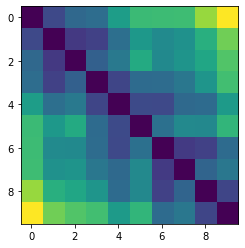

- Frame 25274


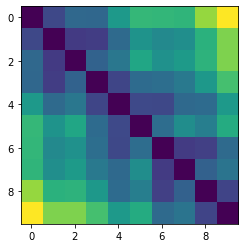

- Frame 46684


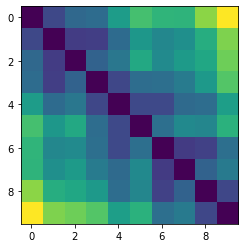

- Frame 33331


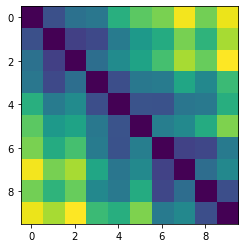

- Frame 27624


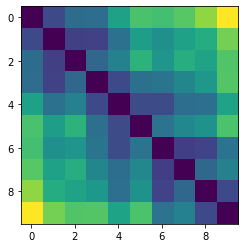

- Frame 779


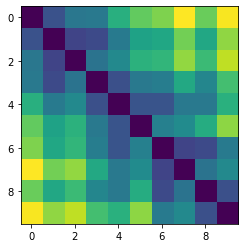

- Frame 1815


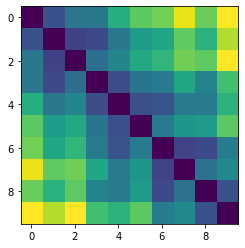

- Frame 38312


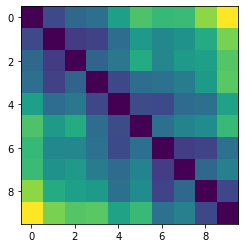

- Frame 10070


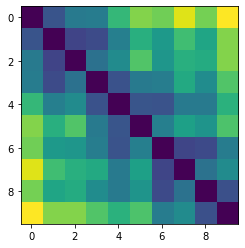

- Frame 44272


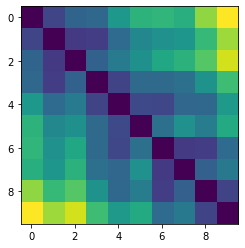

In [22]:
for i in np.random.choice(all_dmap.shape[0], 10, replace=False):
    print("- Frame", i)
    plt.imshow(all_dmap[i])
    plt.show()

Now let's plot the distance distributions of all the inter-atomic distances in our molecule.

Note: if our molecule has `N` atoms, we will have a total of `(Nx(N-1))/2` inter-atomic distances.

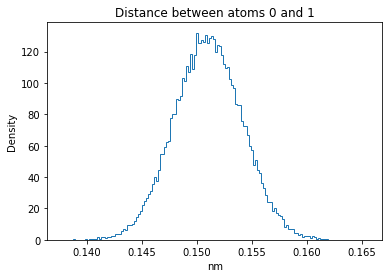

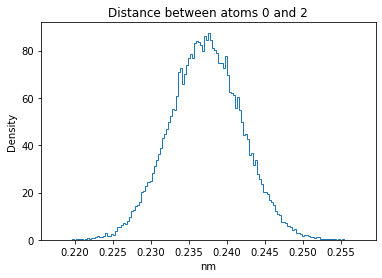

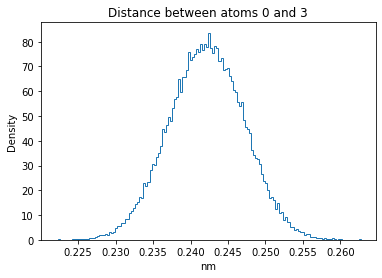

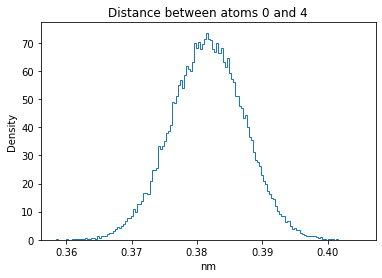

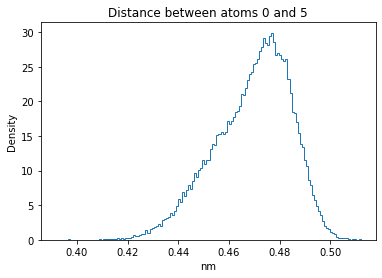

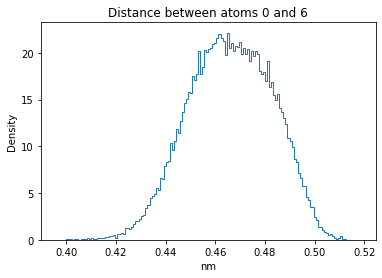

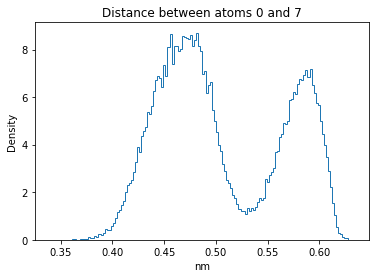

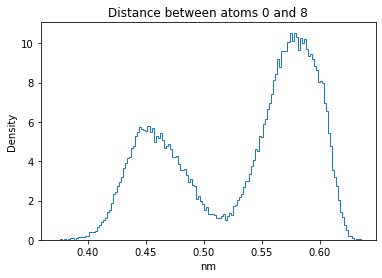

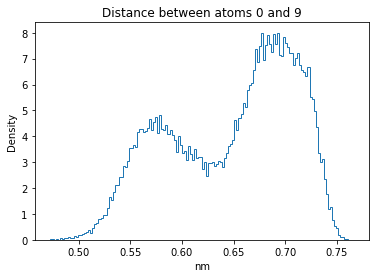

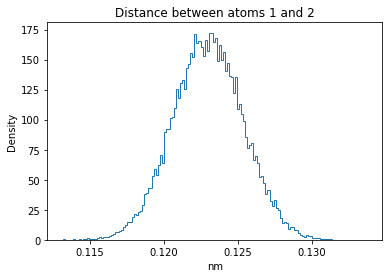

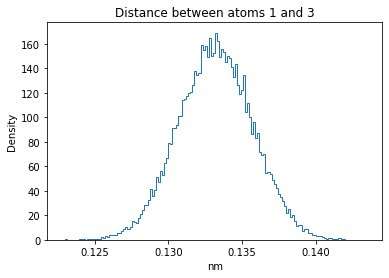

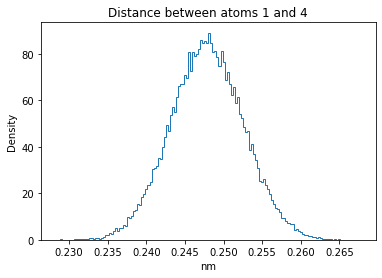

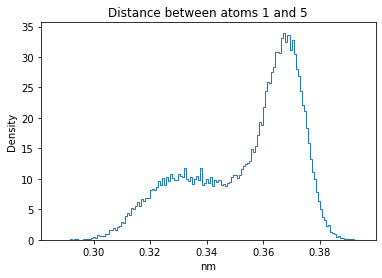

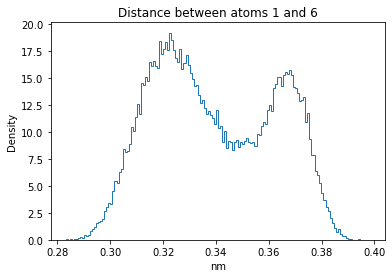

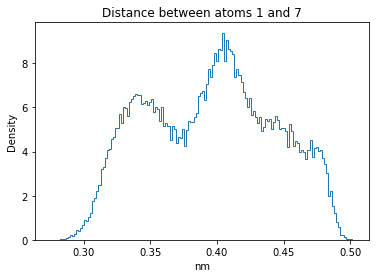

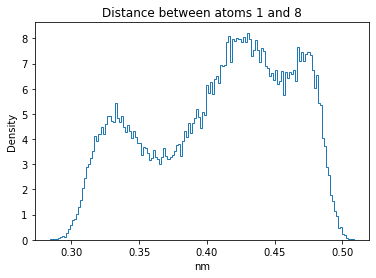

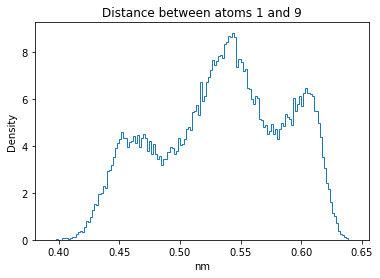

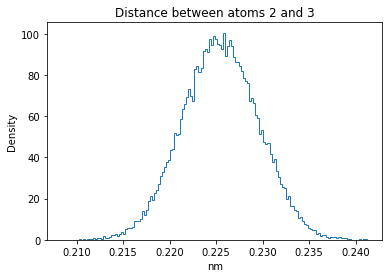

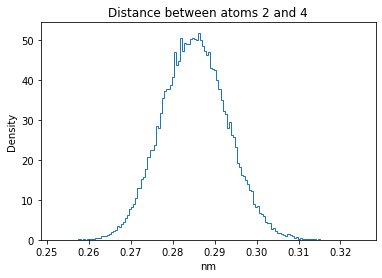

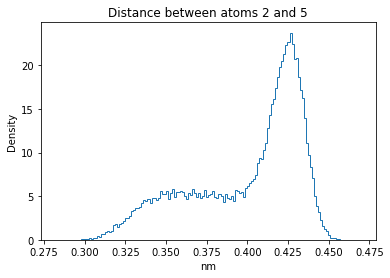

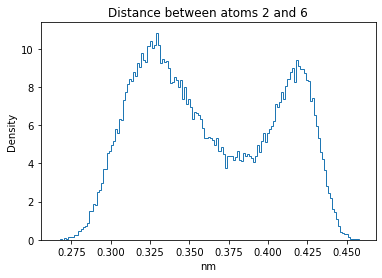

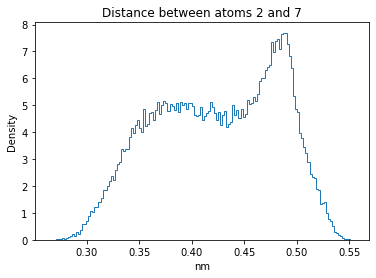

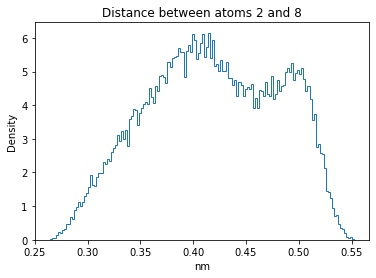

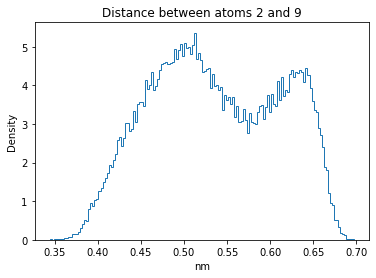

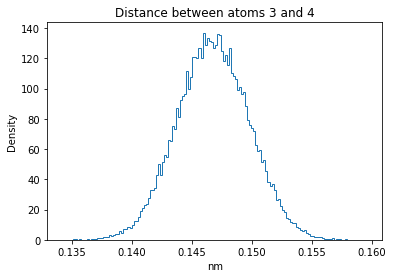

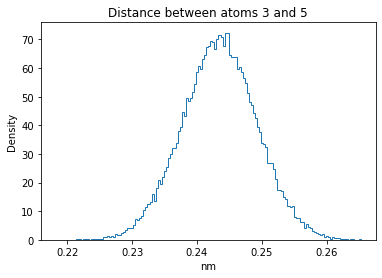

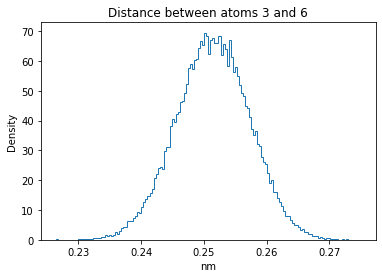

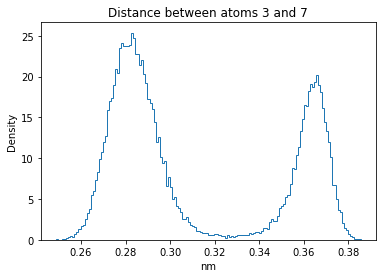

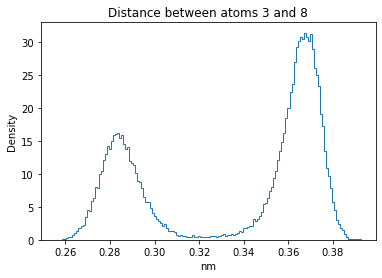

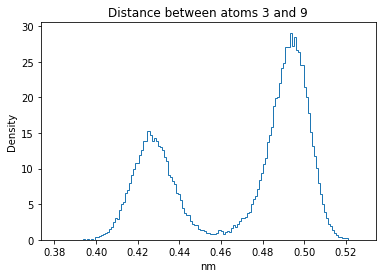

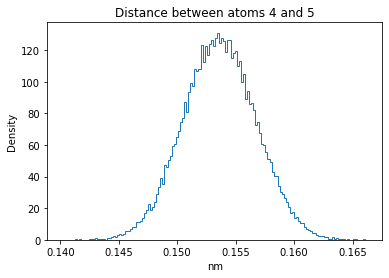

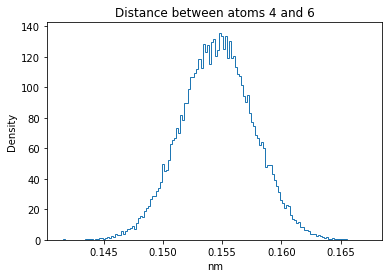

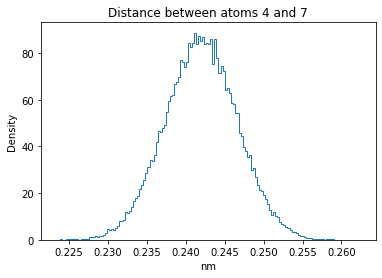

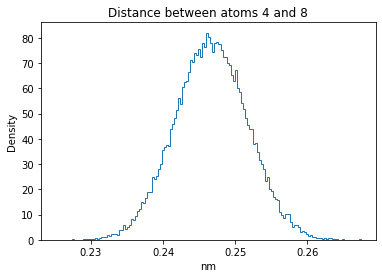

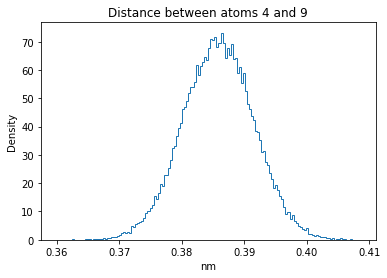

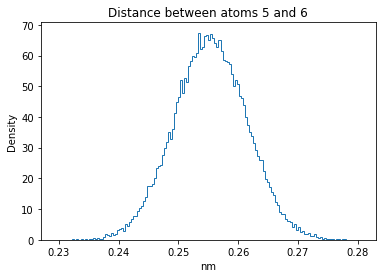

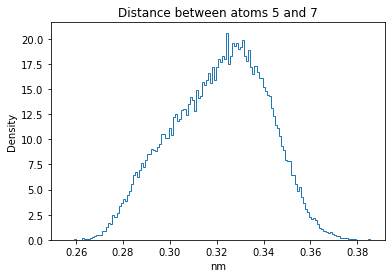

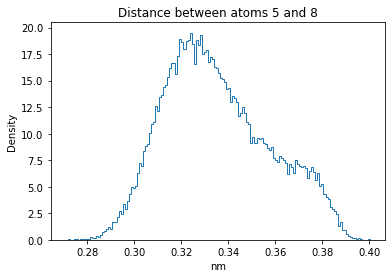

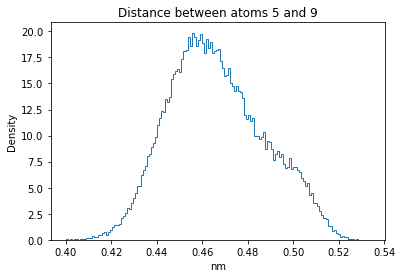

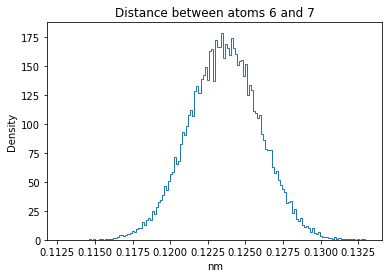

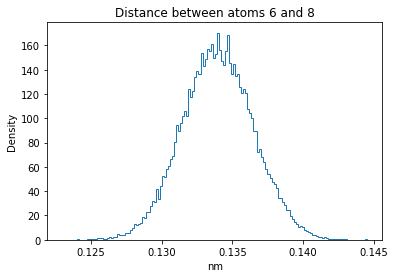

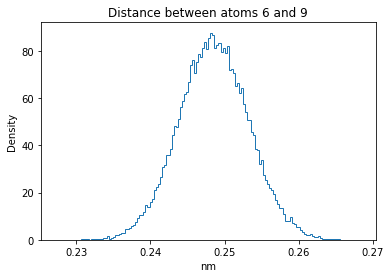

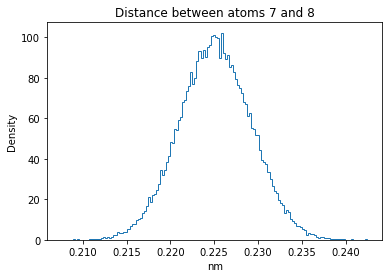

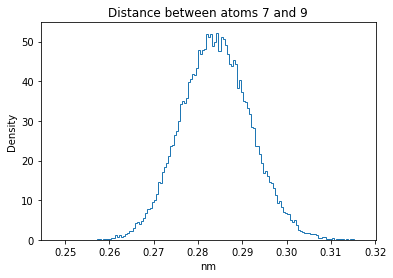

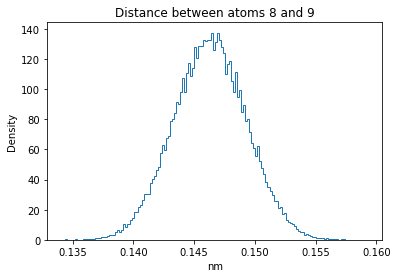

In [23]:
for i in range(n_atoms):
    for j in range(n_atoms):
        if i >= j:
            continue
        plt.title("Distance between atoms %s and %s" % (i, j))
        plt.hist(all_dmap[:,i,j], histtype="step", bins=150, density=True)
        plt.xlabel("nm")
        plt.ylabel("Density")
        plt.show()

How do the distributions look like? Are there some multi-modal distributions? If you find some some multi-modal distributions, why do you think they are in our MD data for this molecule? And also, how come some distribution are mono-modal and some multi-modal? Please take a moment to briefly discuss!

### Ramachandran plot

To better understand our data, we will also plot it's Ramachandran plot with a function that uses `mdtraj` and `matplotlib`.

In [24]:
def show_ramachandran_plot(m_traj):
    all_phi = mdtraj.compute_phi(m_traj)[1][:,0]
    all_psi = mdtraj.compute_psi(m_traj)[1][:,0]
    plt.figure(figsize=(4, 4), dpi=100)
    plt.hist2d(all_phi, all_psi, bins=200, cmap=plt.cm.nipy_spectral_r,
               norm=matplotlib.colors.LogNorm())
    plt.title(r"$p_{data}$")
    # plt.title(r"$\mu$")
    plt.xlabel(r"$\phi$")
    plt.ylabel(r"$\psi$")
    plt.xlim([-np.pi, np.pi])
    plt.ylim([-np.pi, np.pi])
    plt.show()

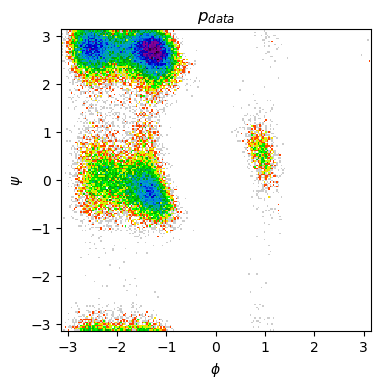

In [25]:
show_ramachandran_plot(m_traj)

Do you notice something that can backup your hypotheses on the presence of multi-modal distributions in our MD data?

## Build and train a Generative Adversarial Network (GAN)

Finally, after inspecting our data, we are ready to build a generative model to model it!

In this lab, we will use a [Generative Adverarial Network](https://arxiv.org/abs/1701.00160) (GAN). We covered some theoretical details in the [past lecture](https://adicksonlab.github.io/ml4md-jb/Week-04/W4_Lecture_GenerativeModels.html), but in this notebook we will review again the main concepts of the method.

We will use the `pytorch` framework to implement our generative model. To review the basic functionalities of PyTorch, please refer to this [tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html).

The GAN implementation that we will use is largely based on this [GAN tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) on the Pytorch website.

Feel free to check these tutorials if you want to review and better understand the details of today's lab.

### Dataloader

A PyTorch `DataLoader` object will be necessary to split our training set in random batches and store our data in `Tensor` objects, which are the PyTorch equivalent for NumPy arrays.

Note that the size of our batches is an important hyper-parameter of our neural network training, which you might need to fine-tune empirically. See this [blog post](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/) for an introductory discussion if you are interested.

In [26]:
batch_size = 128  # This batch size value is probably good for today's learning task.
                  # Feel free to experiment with other values!
dataloader = torch.utils.data.DataLoader(all_xyz,
                                         batch_size=batch_size,
                                         shuffle=True)

In [27]:
total_frames = 0
for b in dataloader:
    total_frames += b.shape[0]
    print("- Current batch shape: %s, total frames so far: %s" % (
          repr(b.shape), total_frames))

- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 128
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 256
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 384
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 512
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 640
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 768
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 896
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 1024
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 1152
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 1280
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 1408
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 1536
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 1664
- Current batch shape: torch.Siz

- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 20224
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 20352
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 20480
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 20608
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 20736
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 20864
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 20992
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 21120
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 21248
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 21376
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 21504
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 21632
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 21760
- Current ba

- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 40448
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 40576
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 40704
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 40832
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 40960
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 41088
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 41216
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 41344
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 41472
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 41600
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 41728
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 41856
- Current batch shape: torch.Size([128, 10, 3]), total frames so far: 41984
- Current ba

### Build our Generator network

Time to build our Generator network. We will use a simple [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP) architecture, which should be more than enough to model our small molecule. Check also its image from [Week 2 lecture](https://adicksonlab.github.io/ml4md-jb/Week-02/W2_Lecture_MLBasics.html#neural-networks).

The generator is a network that takes as input a random noise vector `z` and maps it to some other vector `x` using some complicated function (we use a MLP). We want to train our generator to learn a function that maps `z` to `x` values that represent "realistic" 3D conformations.

We will use `16` as the dimension of our latent space from where the `z` vectors are sampled. Again, this is some hyper-parameter that would need fine-tuning, but `16` is probably a good value here. Usually, the dimension of `z` is supposed to be lower than that `x`.

In [64]:
n_z = 4  # Latent space dimension.
hidden_dim_g = 196  # Number of hidden units in our generator MLP.
                    # In GANs, the competing generator and discriminator should be "balanced"
                    # so we will need to use a similar value for the discriminator (see below).

In [65]:
class Generator(nn.Module):
    
    def __init__(self, n_z, n_atoms, hidden_dim=32,
                 activation="relu",
                 layer_norm=None):
        """
        Define our neural network layers.
        """
        super(Generator, self).__init__()
        self.n_atoms = n_atoms
        self.input_layer = nn.Linear(n_z, hidden_dim)
        self.act_0 = nn.ReLU()
        self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.act_1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, n_atoms*3)
    
    def forward(self, z):
        """
        This function is called when we run an instance of our
        neural network.
        """
        h = self.input_layer(z)
        h = self.act_0(h)
        h = self.hidden_layer_1(h)
        h = self.act_1(h)
        x_gen = self.output_layer(h)
        # We reshape to a xyz tensor in the mdtraj (T, N, 3) style.
        x_gen = x_gen.reshape(-1, self.n_atoms, 3)
        return x_gen

net_g = Generator(n_z=n_z, n_atoms=n_atoms, hidden_dim=hidden_dim_g)
net_g = net_g.to(device)

print(net_g)

Generator(
  (input_layer): Linear(in_features=4, out_features=196, bias=True)
  (act_0): ReLU()
  (hidden_layer_1): Linear(in_features=196, out_features=196, bias=True)
  (act_1): ReLU()
  (output_layer): Linear(in_features=196, out_features=30, bias=True)
)


Let's check what the generator is doing. Above you should see a scheme of its architecture.

Why is `16` the dimension of its input vectors? Why is `30` the dimension of its output vectors? What do these `30` numbers represent?

The cell below will allow you to run our (untrained) generator. What is its output?

In [66]:
with torch.no_grad():
    # Let's generate a batch of 32 random noise vectors.
    z_check = torch.randn(32, n_z, device=device)
    print("- z shape:", z_check.shape)
    # Let's run the generator.
    x_check = net_g(z_check)
    print("- x_gen shape:", x_check.shape)

- z shape: torch.Size([32, 4])
- x_gen shape: torch.Size([32, 10, 3])


### Build our Discriminator network

Finally, let's build our Discriminator network. We will again use a simple [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) (MLP) architecture.

The discriminator is a network that takes as input a vector `x` and maps it to a scalar value in the `0-1` interval using some complicated function (we use a MLP).

In GAN training, we want to train our discriminator in a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, where our two classes are "fake conformation" (represented by a `0`) and "real conformantion" (represented by a `1`).

In GAN training, "fake" means a `x` comining from the generator, while "real" means a `x` coming from the training data.

In other words, when we feed to the discriminator a "fake" `x`, we would like it to output a number close to `0`, when we feed it a "real" `x`, we would like a output close to `1`.

**Optional**. Two last notes about the discriminator.

* GAN training is typically instable. There are many techniques that attempt to stabilize it. Today we will use [spectral normalization](https://arxiv.org/abs/1802.05957) on the discriminator weights. It is a computationally light method and it is already implemented as a PyTorch functionality. Its effect is to regularize the discriminator by forcing it to learn a "smoother" function, something that appears to stabilize GAN training.

* To numerically help neural network training, we also use a [Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardize each atom coordinate using its mean and standard deviation values from the training set. A similar (but more complex) approach is followed for example in [[Noe et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31488660/)].

If you want to check what happens without these features, feel free to set our `use_spectral_norm` or `use_scaler` variables to `False`!

In [67]:
hidden_dim_d = 128
use_spectral_norm = True
use_scaler = True

In [68]:
all_xyz.shape

(50000, 10, 3)

In [69]:
class StandardScaler:
    
    def __init__(self):
        self.m = None
        self.s = None
        
    def fit(self, xyz):
        self.m = torch.tensor(xyz.reshape(-1, n_atoms*3).mean(axis=0), device=device).reshape(1, -1)
        self.s = torch.tensor(xyz.reshape(-1, n_atoms*3).std(axis=0), device=device).reshape(1, -1)
    
    def transform(self, xyz):
        return (self.m-xyz)/self.s
    
scaler = StandardScaler()
scaler.fit(all_xyz)

In [70]:
class Discriminator(nn.Module):
    
    def __init__(self, n_atoms, hidden_dim=32,
                 use_scaler=False,
                 use_spectral_norm=False):
        
        super(Discriminator, self).__init__()
        self.n_atoms = n_atoms
        self.use_scaler = use_scaler
        self.use_spectral_norm = use_spectral_norm
        
        self.input_layer = nn.Linear(n_atoms*3, hidden_dim)
        if self.use_spectral_norm:
            self.input_layer = torch.nn.utils.spectral_norm(self.input_layer)
        self.act_0 = nn.ReLU()
        self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        if self.use_spectral_norm:
            self.hidden_layer_1 = torch.nn.utils.spectral_norm(self.hidden_layer_1)
        self.act_1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_dim, 1)
        if self.use_spectral_norm:
            self.output_layer = torch.nn.utils.spectral_norm(self.output_layer)
        self.act_sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.reshape(-1, self.n_atoms*3)
        if self.use_scaler:
            x = scaler.transform(x)
        h = self.input_layer(x)
        h = self.act_0(h)
        h = self.hidden_layer_1(h)
        h = self.act_1(h)
        o = self.output_layer(h)
        o = self.act_sigmoid(o)
        return o

net_d = Discriminator(n_atoms=n_atoms, hidden_dim=hidden_dim_d,
                      use_spectral_norm=use_spectral_norm,
                      use_scaler=use_scaler)
net_d = net_d.to(device)

print(net_d)

Discriminator(
  (input_layer): Linear(in_features=30, out_features=128, bias=True)
  (act_0): ReLU()
  (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
  (act_1): ReLU()
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (act_sigmoid): Sigmoid()
)


Let's check what the discriminator is doing. Above you should see a scheme of its architecture.

Why is `30` the dimension of its input vectors? Why is `1` the dimension of its output?

The cell below will allow you to run our (untrained) discriminator. What is its output? Notice how its output is a number between 0 and 1 (an untrained discriminator should output some random number close to `0.5`).

In [71]:
with torch.no_grad():
    # We extract a batch of training data.
    x_check = next(dataloader.__iter__())
    x_check = x_check.to(device)
    print("- x_ref shape:", x_check.shape)
    # We give it as input to the discriminator.
    out_check = net_d(x_check)
    print("- discriminator output shape:", out_check.shape)
    print("- First 10 elements of the output:", out_check[0:10])

- x_ref shape: torch.Size([128, 10, 3])
- discriminator output shape: torch.Size([128, 1])
- First 10 elements of the output: tensor([[0.5348],
        [0.5043],
        [0.4772],
        [0.5041],
        [0.5518],
        [0.4964],
        [0.4849],
        [0.5096],
        [0.4949],
        [0.5098]])


## Optimizers and Loss Functions

We are almost ready to train our GAN! Let's create our `Adam` optimizers to perform gradient-based optimization of neural network parameters. [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) is a more sophisticated version of the basic [Steepest Descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm (which you may know from Molecular Mechanics), it is the default choice of almost all machine learning practitioners.

In [72]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
learning_rate = 0.00025
beta1 = 0.25
optimizer_d = optim.Adam(net_d.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_g = optim.Adam(net_g.parameters(), lr=learning_rate, betas=(beta1, 0.999))

Here we create our loss function. Today, we will use a slightly modified version of the [original GAN objective]().

This modification is called the non-saturated GAN loss and was discussed in the original [GAN article](https://arxiv.org/abs/1406.2661) as a form of improvement over the original minmax objective.

Here is its formula (image from [[Che et al., 2020](https://arxiv.org/abs/2003.06060)]):

<img alt="non-saturated GAN loss" src="https://raw.githubusercontent.com/ADicksonLab/ml4md-jb/main/Week-04/non_saturated_gan_loss.png" width="500px"/>


Where:
* *L<sub>D</sub>* is the discriminator loss and *L<sub>G</sub>* is the generator loss.
* *D(**x**)* is the discriminator output (a scalar from 0 to 1).
* *G(**z**)* is the generator output, a "fake" conformation ***x***.
* The [Expected_value](https://en.wikipedia.org/wiki/Expected_value) is computed over:
    * *p<sub>data</sub>* (something that we approximate by sampling batches of conformation from our training set)
    * *p<sub>z</sub>* (something that we approximate by generating random samples by sampling from our simple prior).

In our GAN implemenentation, for each mini-batch will first train the discriminator by using *L<sub>D</sub>*, and then the generator using *L<sub>G</sub>*.

What is the goal of training with these functions?

In [73]:
# Initialize BCELoss function, which we will use to compute L_D and L_G.
criterion = nn.BCELoss()

Create batch of latent vectors that we will use to visualize the progression of the generator.

In [74]:
z_fixed = torch.randn(10000, n_z, device=device)

## Functions to train the model

Now we are ready to train! In the cell below there is function that implement GAN training for `num_epochs`. In machine learning a training epoch is a pass through all the training examples. GAN training can be quite slow sometimes, so you may need to train at least 50 epochs to see some acceptable results.

In [75]:
def score_kl_approximation(v_true, v_pred, n_bins=50, pseudo_c=0.00001):
    # Define bins.
    _min = min((v_true.min(), v_pred.min()))
    _max = max((v_true.max(), v_pred.max()))
    bins = np.linspace(_min, _max, n_bins+1)
    # Compute the frequencies in the bins.
    ht = (np.histogram(v_true, bins=bins)[0]+pseudo_c)/v_true.shape[0]
    hp = (np.histogram(v_pred, bins=bins)[0]+pseudo_c)/v_pred.shape[0]
    kl = -np.sum(ht*np.log(hp/ht))
    return kl, bins

In [76]:
def train(num_epochs):

    # Lists to keep track of progress.
    history = []

    print("Starting Training Loop...\n")

    # For each epoch
    for epoch in range(num_epochs):
    
        print("\n# Epoch %s of %s" % (epoch, num_epochs))
        
        # We set to training mode our networks.
        net_d.train()
        net_g.train()

        epoch_data = {"loss_d": 0, "loss_g": 0,
                      "D_x": 0,
                      "D_G_z1": 0,
                      "D_G_z2": 0,
                      "epoch_elements": 0}

        # For each batch in the dataloader
        for i, x_real in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################

            ## Train with all-real batch

            # Zero-out the gradients of netD.
            net_d.zero_grad()

            # Format batch
            x_real = x_real.to(device)
            b_size = x_real.size(0)

            # Store the number of samples processed in this epoch.
            epoch_data["epoch_elements"] += b_size

            # Create a tensor with shape (b_size,) with only 1 values,
            # since 1 is the label of real samples.
            label = torch.ones((b_size,), dtype=torch.float, device=device)

            # Forward pass real batch through D.
            # We use.view(-1) to reshape from (b_size, 1) -> (b_size, )
            out_real = net_d(x_real).view(-1)

            # Calculate loss on all-real batch.
            # We want to maximize log(D(x)).
            loss_d_real = criterion(out_real, label)

            # Calculate gradients for D in backward pass
            loss_d_real.backward()

            # Stores data for calculating D_x for this epoch.
            epoch_data["D_x"] += out_real.sum().item()


            ## Train with all-fake batch
            # Generate batch of latent vectors
            z = torch.randn(b_size, n_z, device=device)

            # Generate fake image batch with G
            x_fake = net_g(z)

            # Now we fill the label tensor with 0, since that is the label of fakes
            # samples.
            label.fill_(fake_label)

            # Classify all fake batch with D.
            # Note: detach() is needed, since we want to take x_fake out of the
            # computational graph: we are not interested in calculating the gradient
            # with respect to netG parameters now (we must do it later when updating
            # netG). This means that we are treating x_fake as some "constant" input
            # for the netD (just like x_true).
            out_fake = net_d(x_fake.detach()).view(-1)

            # Calculate D's loss on the all-fake batch.
            # We want to minimize log(1 - D(G(z)).
            loss_d_fake = criterion(out_fake, label)

            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            loss_d_fake.backward()

            # Compute the accuracy of netD predictions.
            epoch_data["D_G_z1"] += out_fake.sum().item()

            # Compute error of D as sum over the fake and the real batches
            loss_d = loss_d_fake + loss_d_fake

            # Store the loss_d values.
            epoch_data["loss_d"] += loss_d.item()*b_size

            # Update D
            optimizer_d.step()


            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################

            # Zero-out netG gradients.
            net_g.zero_grad()

            label.fill_(real_label)  # fake labels are real for generator cost

            # Since we just updated D, perform another forward pass of all-fake batch through D
            out_fake = net_d(x_fake).view(-1)

            # Calculate G's loss based on this output.
            # We want to maximize log(D(G(z))).
            loss_g = criterion(out_fake, label)

            # Store the loss_g values.
            epoch_data["loss_g"] += loss_g.item()*b_size

            # Calculate gradients for G
            loss_g.backward()

            # Calculate the accuracy for D after it was updated.
            epoch_data["D_G_z2"] = out_fake.sum().item()

            # Update G
            optimizer_g.step()
        
        # We set to eval mode our networks.
        net_d.eval()
        net_g.eval()
        
        # Generate random conformations to check how training is going.
        with torch.no_grad():
            x_gen_fixed = net_g(z_fixed).cpu().numpy()
            dmap_gen_fixed = convert_xyz_to_dmap(x_gen_fixed)
        
        # Evaluate all the inter-atomic distance distributions.
        kl_list = []
        for i in range(n_atoms):
            for j in range(n_atoms):
                if i >= j:
                    continue
                dist_ref = all_dmap[:,i, j]
                dist_gen = dmap_gen_fixed[:,i, j]
                kl_i = score_kl_approximation(dist_ref, dist_gen)[0]
                kl_list.append(kl_i)
                
        # Updates the history (divide each value by the number of elements
        # processed in this epoch, so that we have average values for the epoch.
        for key in list(epoch_data.keys()):
            if key == "epoch_elements":
                continue
            epoch_data[key] = epoch_data[key]/epoch_data["epoch_elements"]
        epoch_data["average_kld"] = np.mean(kl_list)
        history.append(epoch_data)
        
        # Output training process stats.
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
              % (epoch, num_epochs,
                 epoch_data["loss_d"], epoch_data["loss_g"],
                 epoch_data["D_x"], epoch_data["D_G_z1"]))
        print("\tAverage KLD for all inter-atomic distances: %s" % round(np.mean(kl_list), 4))

        # Plot some distance distributions.
        if epoch % 5 == 0:
            n_hist = 4
            fig, ax = plt.subplots(1, n_hist, figsize=(12, 3.0))
            h_args = {"histtype": "step", "density": True, "bins": 50}
            for k in range(n_hist):
                atm_i, atm_j = np.random.choice(n_atoms, 2, replace=False)
                dist_ref = all_dmap[:,atm_i, atm_j]
                dist_gen = dmap_gen_fixed[:,atm_i, atm_j]
                kl_i = score_kl_approximation(dist_ref, dist_gen)[0]
                ax[k].set_title("Distance %s-%s (KL = %s)" % (atm_i, atm_j, round(kl_i, 3)))
                ax[k].hist(dist_ref, label="MD", **h_args)
                ax[k].hist(dist_gen, label="GEN", **h_args)
            plt.legend()
            plt.show()
            
    return history

Here you can run the training. Start with 50 epochs. If you feel that the results are not yet acceptable, run again this cell to train for more epochs (you can also modify the number of epochs).

During training, we will evaluate the divergence between the reference (from MD) and generated (from our GAN) distance distributions using an approximation of the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence). The lower this score is, the more the two distribution are similar (if distributions are equal, KLD would be 0).

Check your average KLD! If, after some epochs it is not improving, there is probably no point in training longer.

To visually check how well our generator is modeling the distance distributions, we also plot some histograms every 5 epochs.

Starting Training Loop...


# Epoch 0 of 50
[0/50]	Loss_D: 0.2939	Loss_G: 3.3048	D(x): 0.6044	D(G(z)): 0.1026
	Average KLD for all inter-atomic distances: 1.6616


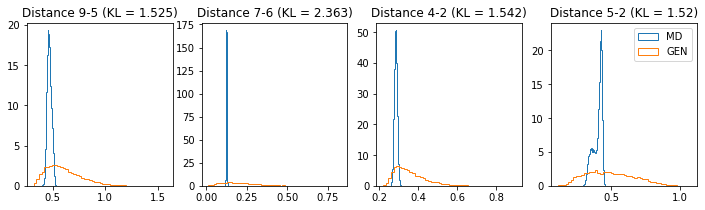


# Epoch 1 of 50
[1/50]	Loss_D: 0.3500	Loss_G: 2.4367	D(x): 0.7458	D(G(z)): 0.1498
	Average KLD for all inter-atomic distances: 1.2268

# Epoch 2 of 50
[2/50]	Loss_D: 0.4514	Loss_G: 2.1169	D(x): 0.7753	D(G(z)): 0.1882
	Average KLD for all inter-atomic distances: 1.1237

# Epoch 3 of 50
[3/50]	Loss_D: 0.4859	Loss_G: 2.1314	D(x): 0.7860	D(G(z)): 0.1979
	Average KLD for all inter-atomic distances: 1.0207

# Epoch 4 of 50
[4/50]	Loss_D: 0.5891	Loss_G: 1.8881	D(x): 0.7702	D(G(z)): 0.2338
	Average KLD for all inter-atomic distances: 0.9749

# Epoch 5 of 50
[5/50]	Loss_D: 0.6287	Loss_G: 1.8017	D(x): 0.7564	D(G(z)): 0.2475
	Average KLD for all inter-atomic distances: 0.9421


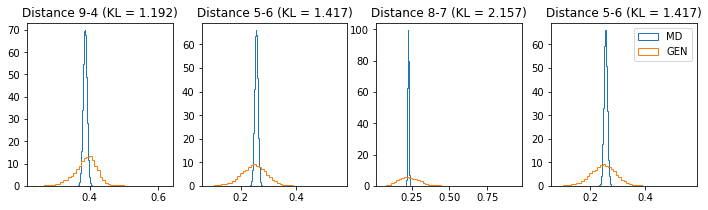


# Epoch 6 of 50
[6/50]	Loss_D: 0.6326	Loss_G: 1.8902	D(x): 0.7531	D(G(z)): 0.2443
	Average KLD for all inter-atomic distances: 0.9153

# Epoch 7 of 50
[7/50]	Loss_D: 0.5837	Loss_G: 1.8274	D(x): 0.7597	D(G(z)): 0.2346
	Average KLD for all inter-atomic distances: 0.8936

# Epoch 8 of 50
[8/50]	Loss_D: 0.6218	Loss_G: 1.5838	D(x): 0.7497	D(G(z)): 0.2550
	Average KLD for all inter-atomic distances: 0.825

# Epoch 9 of 50
[9/50]	Loss_D: 0.6164	Loss_G: 1.7354	D(x): 0.7536	D(G(z)): 0.2467
	Average KLD for all inter-atomic distances: 0.8135

# Epoch 10 of 50
[10/50]	Loss_D: 0.6565	Loss_G: 1.7242	D(x): 0.7480	D(G(z)): 0.2573
	Average KLD for all inter-atomic distances: 0.7954


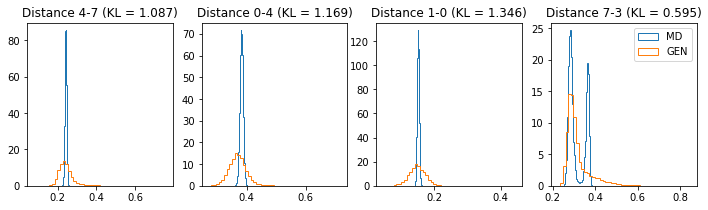


# Epoch 11 of 50
[11/50]	Loss_D: 0.6941	Loss_G: 1.6562	D(x): 0.7354	D(G(z)): 0.2697
	Average KLD for all inter-atomic distances: 0.7579

# Epoch 12 of 50
[12/50]	Loss_D: 0.7132	Loss_G: 1.6435	D(x): 0.7288	D(G(z)): 0.2744
	Average KLD for all inter-atomic distances: 0.7299

# Epoch 13 of 50
[13/50]	Loss_D: 0.6547	Loss_G: 1.7107	D(x): 0.7371	D(G(z)): 0.2568
	Average KLD for all inter-atomic distances: 0.8327

# Epoch 14 of 50
[14/50]	Loss_D: 0.6157	Loss_G: 1.5941	D(x): 0.7451	D(G(z)): 0.2527
	Average KLD for all inter-atomic distances: 0.7141

# Epoch 15 of 50
[15/50]	Loss_D: 0.7035	Loss_G: 1.3889	D(x): 0.7175	D(G(z)): 0.2865
	Average KLD for all inter-atomic distances: 0.7319


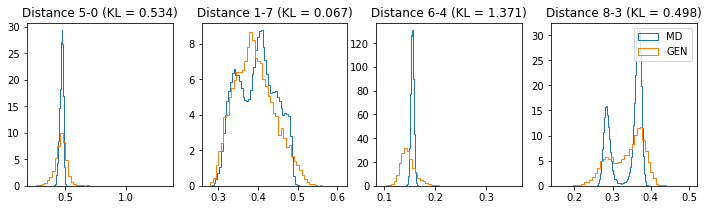


# Epoch 16 of 50
[16/50]	Loss_D: 0.6473	Loss_G: 1.6265	D(x): 0.7368	D(G(z)): 0.2593
	Average KLD for all inter-atomic distances: 0.6949

# Epoch 17 of 50
[17/50]	Loss_D: 0.7069	Loss_G: 1.5869	D(x): 0.7282	D(G(z)): 0.2757
	Average KLD for all inter-atomic distances: 0.6139

# Epoch 18 of 50
[18/50]	Loss_D: 0.7367	Loss_G: 1.5563	D(x): 0.7197	D(G(z)): 0.2843
	Average KLD for all inter-atomic distances: 0.5917

# Epoch 19 of 50
[19/50]	Loss_D: 0.7371	Loss_G: 1.5442	D(x): 0.7168	D(G(z)): 0.2847
	Average KLD for all inter-atomic distances: 0.5693

# Epoch 20 of 50
[20/50]	Loss_D: 0.7035	Loss_G: 1.5497	D(x): 0.7209	D(G(z)): 0.2767
	Average KLD for all inter-atomic distances: 0.5697


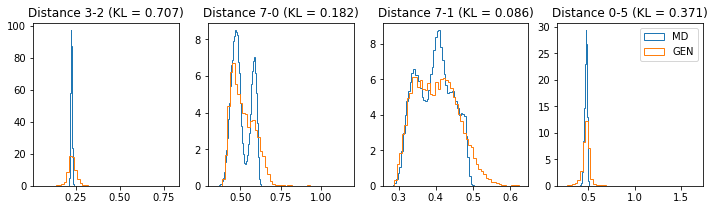


# Epoch 21 of 50
[21/50]	Loss_D: 0.6863	Loss_G: 1.4516	D(x): 0.7188	D(G(z)): 0.2785
	Average KLD for all inter-atomic distances: 0.5905

# Epoch 22 of 50
[22/50]	Loss_D: 0.7466	Loss_G: 1.2910	D(x): 0.6986	D(G(z)): 0.3037
	Average KLD for all inter-atomic distances: 0.5662

# Epoch 23 of 50
[23/50]	Loss_D: 0.7158	Loss_G: 1.3951	D(x): 0.7074	D(G(z)): 0.2895
	Average KLD for all inter-atomic distances: 0.5513

# Epoch 24 of 50
[24/50]	Loss_D: 0.7085	Loss_G: 1.5222	D(x): 0.7214	D(G(z)): 0.2794
	Average KLD for all inter-atomic distances: 0.5658

# Epoch 25 of 50
[25/50]	Loss_D: 0.7327	Loss_G: 1.5223	D(x): 0.7171	D(G(z)): 0.2846
	Average KLD for all inter-atomic distances: 0.5438


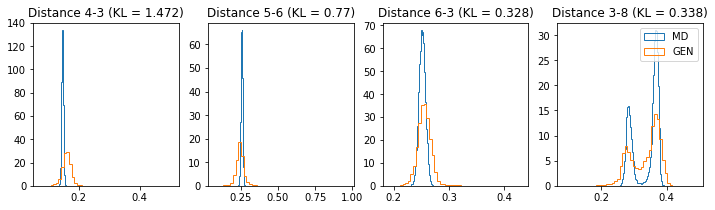


# Epoch 26 of 50
[26/50]	Loss_D: 0.7496	Loss_G: 1.4909	D(x): 0.7125	D(G(z)): 0.2902
	Average KLD for all inter-atomic distances: 0.4739

# Epoch 27 of 50
[27/50]	Loss_D: 0.7590	Loss_G: 1.4542	D(x): 0.7071	D(G(z)): 0.2946
	Average KLD for all inter-atomic distances: 0.4742

# Epoch 28 of 50
[28/50]	Loss_D: 0.7442	Loss_G: 1.4311	D(x): 0.7077	D(G(z)): 0.2926
	Average KLD for all inter-atomic distances: 0.4624

# Epoch 29 of 50
[29/50]	Loss_D: 0.7606	Loss_G: 1.3611	D(x): 0.7002	D(G(z)): 0.3012
	Average KLD for all inter-atomic distances: 0.4551

# Epoch 30 of 50
[30/50]	Loss_D: 0.7842	Loss_G: 1.3309	D(x): 0.6933	D(G(z)): 0.3087
	Average KLD for all inter-atomic distances: 0.4169


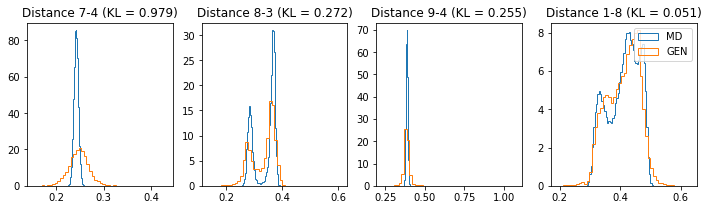


# Epoch 31 of 50
[31/50]	Loss_D: 0.7595	Loss_G: 1.4239	D(x): 0.7037	D(G(z)): 0.2964
	Average KLD for all inter-atomic distances: 0.4321

# Epoch 32 of 50
[32/50]	Loss_D: 0.7532	Loss_G: 1.4515	D(x): 0.7067	D(G(z)): 0.2932
	Average KLD for all inter-atomic distances: 0.3952

# Epoch 33 of 50
[33/50]	Loss_D: 0.7580	Loss_G: 1.4198	D(x): 0.7030	D(G(z)): 0.2966
	Average KLD for all inter-atomic distances: 0.4547

# Epoch 34 of 50
[34/50]	Loss_D: 0.7571	Loss_G: 1.3541	D(x): 0.6990	D(G(z)): 0.3013
	Average KLD for all inter-atomic distances: 0.4425

# Epoch 35 of 50
[35/50]	Loss_D: 0.7816	Loss_G: 1.2561	D(x): 0.6868	D(G(z)): 0.3144
	Average KLD for all inter-atomic distances: 0.4328


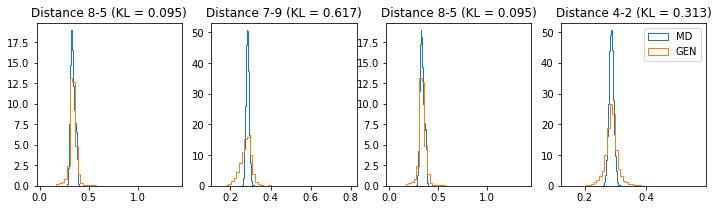


# Epoch 36 of 50
[36/50]	Loss_D: 0.8536	Loss_G: 1.1310	D(x): 0.6620	D(G(z)): 0.3417
	Average KLD for all inter-atomic distances: 0.4272

# Epoch 37 of 50
[37/50]	Loss_D: 0.7324	Loss_G: 1.3819	D(x): 0.7006	D(G(z)): 0.2936
	Average KLD for all inter-atomic distances: 0.483

# Epoch 38 of 50
[38/50]	Loss_D: 0.7588	Loss_G: 1.3946	D(x): 0.7022	D(G(z)): 0.2983
	Average KLD for all inter-atomic distances: 0.3949

# Epoch 39 of 50
[39/50]	Loss_D: 0.7839	Loss_G: 1.3721	D(x): 0.6959	D(G(z)): 0.3056
	Average KLD for all inter-atomic distances: 0.4255

# Epoch 40 of 50
[40/50]	Loss_D: 0.7952	Loss_G: 1.3486	D(x): 0.6917	D(G(z)): 0.3098
	Average KLD for all inter-atomic distances: 0.3735


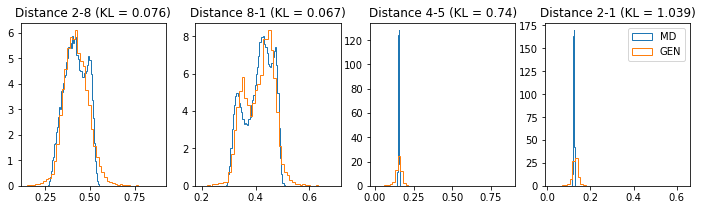


# Epoch 41 of 50
[41/50]	Loss_D: 0.8020	Loss_G: 1.3215	D(x): 0.6885	D(G(z)): 0.3133
	Average KLD for all inter-atomic distances: 0.3797

# Epoch 42 of 50
[42/50]	Loss_D: 0.8065	Loss_G: 1.2954	D(x): 0.6853	D(G(z)): 0.3161
	Average KLD for all inter-atomic distances: 0.3803

# Epoch 43 of 50
[43/50]	Loss_D: 0.7934	Loss_G: 1.3031	D(x): 0.6858	D(G(z)): 0.3127
	Average KLD for all inter-atomic distances: 0.3877

# Epoch 44 of 50
[44/50]	Loss_D: 0.7855	Loss_G: 1.2762	D(x): 0.6857	D(G(z)): 0.3133
	Average KLD for all inter-atomic distances: 0.3845

# Epoch 45 of 50
[45/50]	Loss_D: 0.8437	Loss_G: 1.2114	D(x): 0.6704	D(G(z)): 0.3315
	Average KLD for all inter-atomic distances: 0.3339


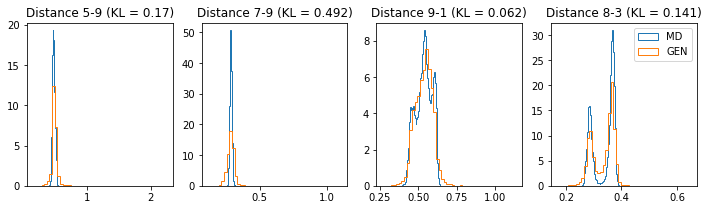


# Epoch 46 of 50
[46/50]	Loss_D: 0.8013	Loss_G: 1.3134	D(x): 0.6856	D(G(z)): 0.3136
	Average KLD for all inter-atomic distances: 0.3541

# Epoch 47 of 50
[47/50]	Loss_D: 0.7877	Loss_G: 1.3402	D(x): 0.6910	D(G(z)): 0.3085
	Average KLD for all inter-atomic distances: 0.3073

# Epoch 48 of 50
[48/50]	Loss_D: 0.8062	Loss_G: 1.3038	D(x): 0.6849	D(G(z)): 0.3154
	Average KLD for all inter-atomic distances: 0.2885

# Epoch 49 of 50
[49/50]	Loss_D: 0.8040	Loss_G: 1.2731	D(x): 0.6822	D(G(z)): 0.3172
	Average KLD for all inter-atomic distances: 0.314


In [77]:
history = train(50)

## Evaluate our GAN

When you are done with training it's time to evaluate our GAN and take a look at some of the generated conformations.

First let's generate the same number of conformations that we have in our training set. We will also time how much it takes for the generator to sample these conformations.

Note that all of these will be independent samples. It would have probably taken much longer to generate via MD the same number of statistically-independent samples!

In [78]:
import time

with torch.no_grad():
    t0 = time.time()
    n_eval = all_xyz.shape[0]
    z_eval = torch.randn(n_eval, n_z, device=device)
    x_gen_eval = net_g(z_eval).cpu().numpy()
    t1 = time.time()
    dmap_gen_eval = convert_xyz_to_dmap(x_gen_eval)
print("- Generated xyz array shape:", x_gen_eval.shape)
print("- It took %s seconds to generate %s independant conformations." % (
      t1-t0, x_gen_eval.shape[0]))

- Generated xyz array shape: (50000, 10, 3)
- It took 0.16701698303222656 seconds to generate 50000 independant conformations.


First let's plot all the inter-atomic distance histograms. Is the GAN capturing multi-modal distributions?

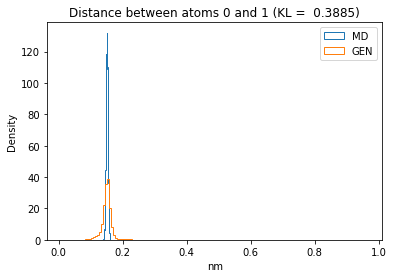

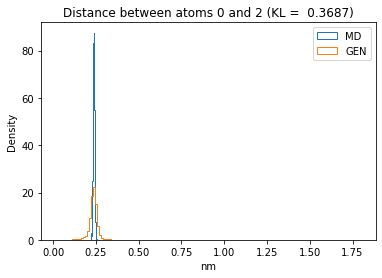

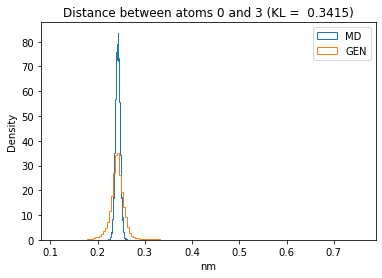

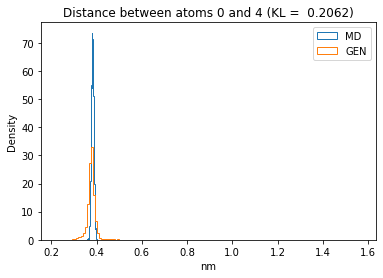

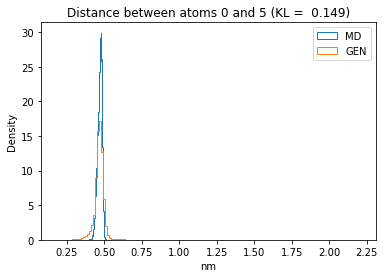

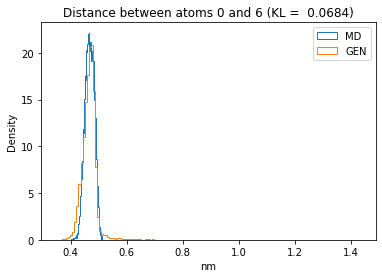

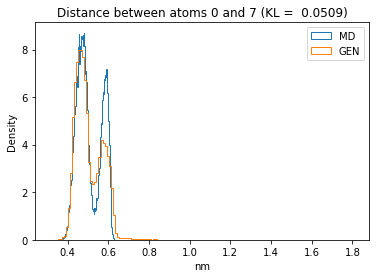

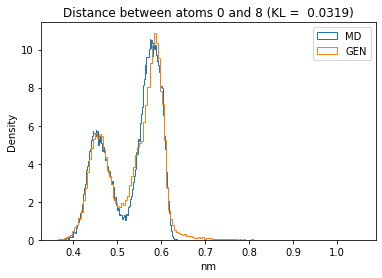

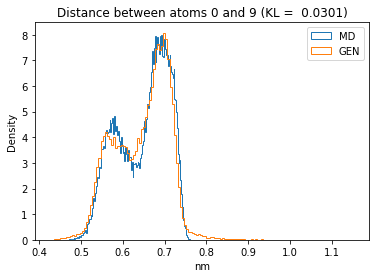

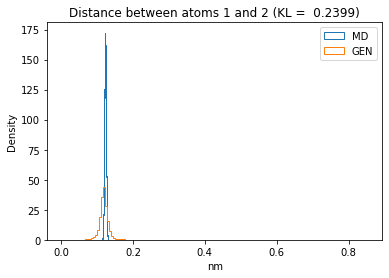

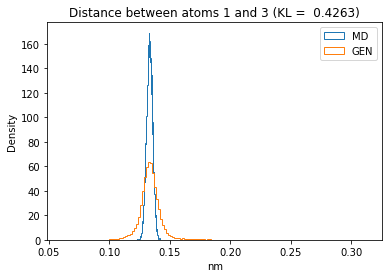

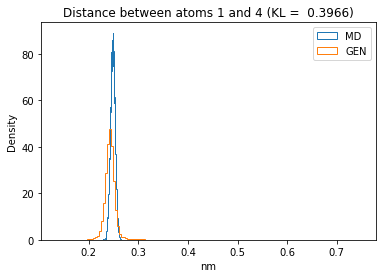

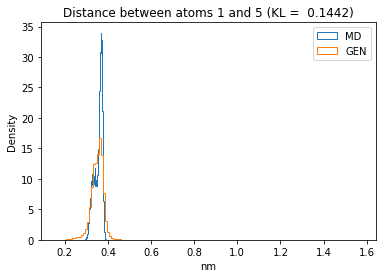

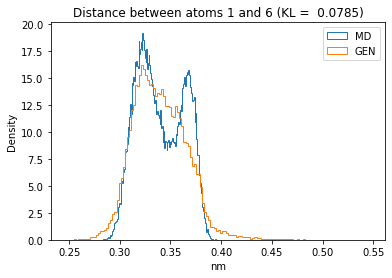

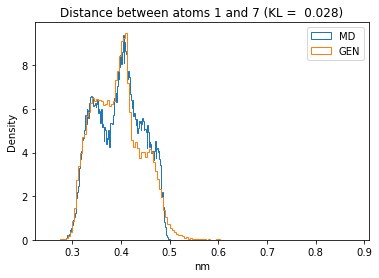

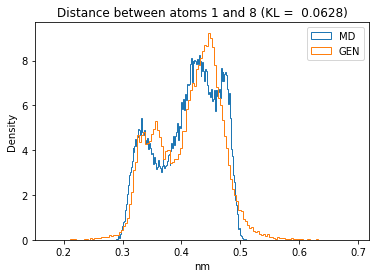

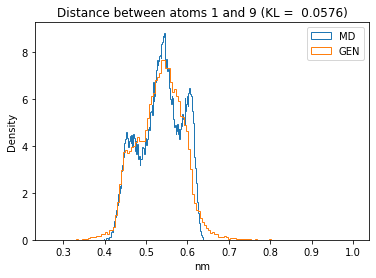

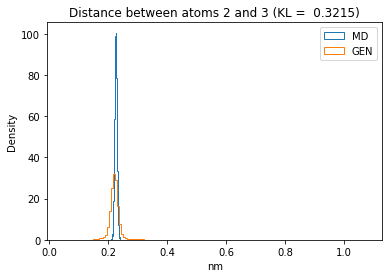

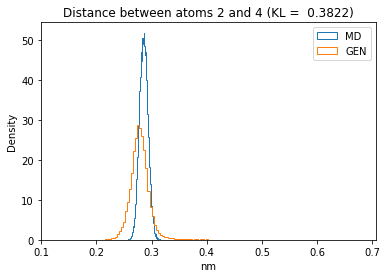

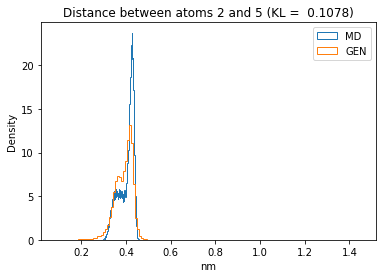

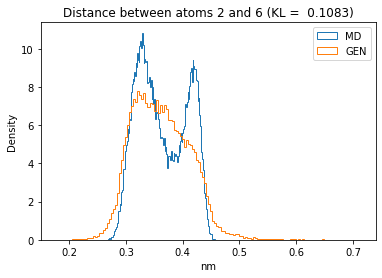

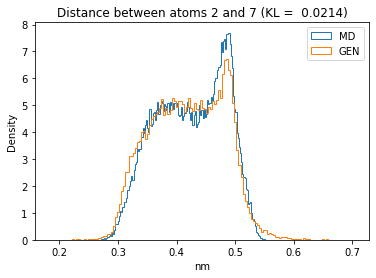

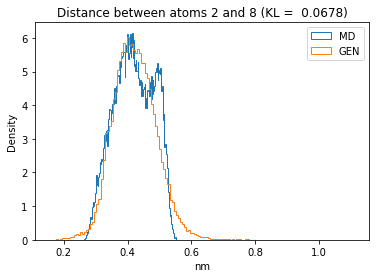

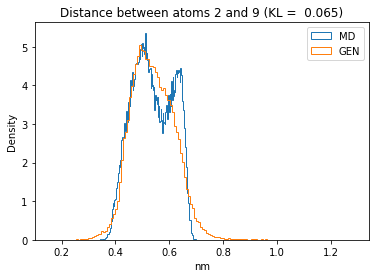

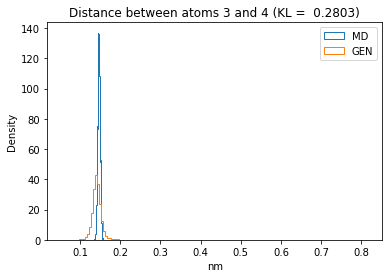

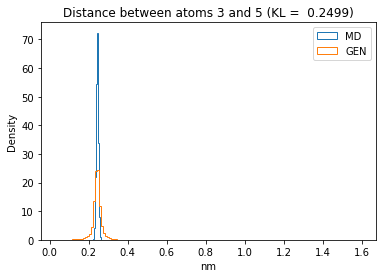

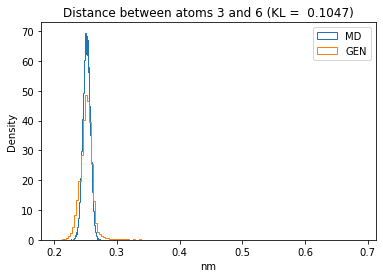

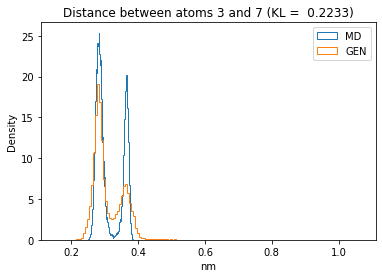

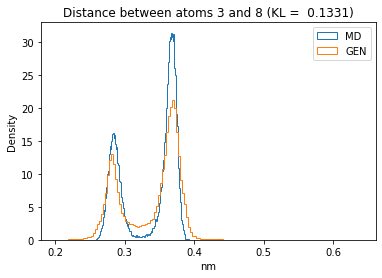

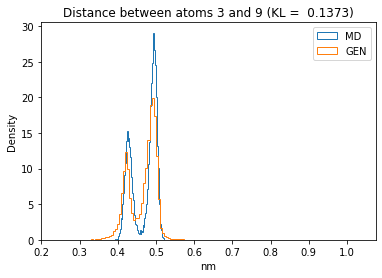

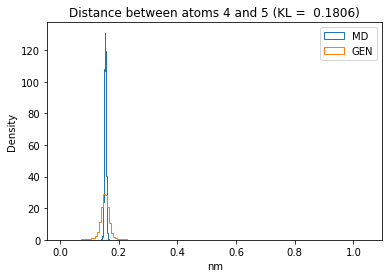

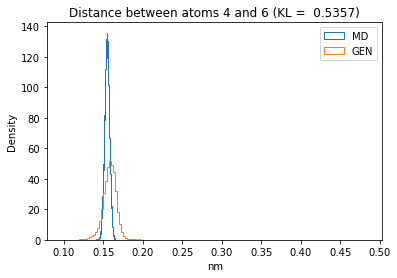

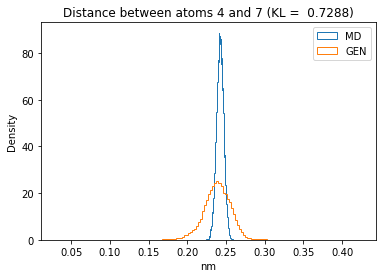

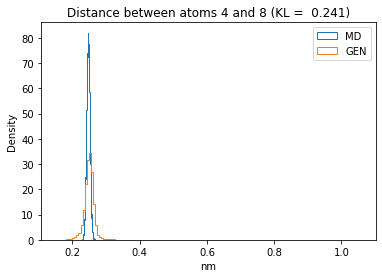

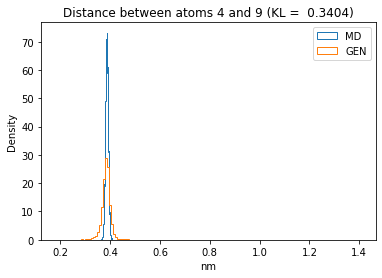

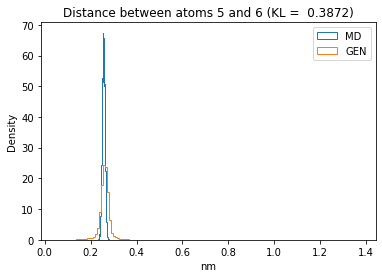

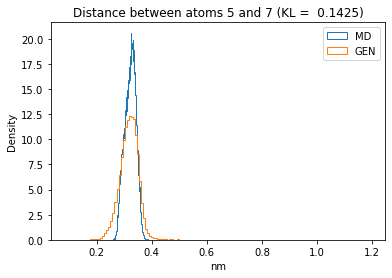

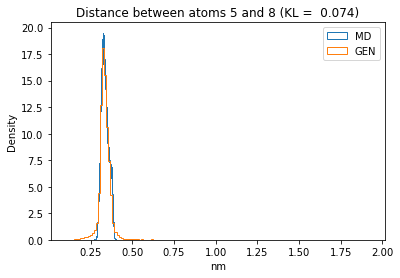

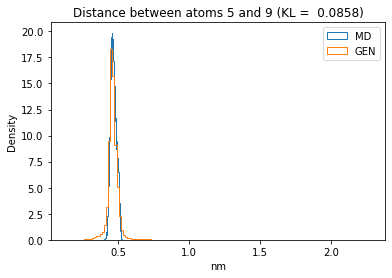

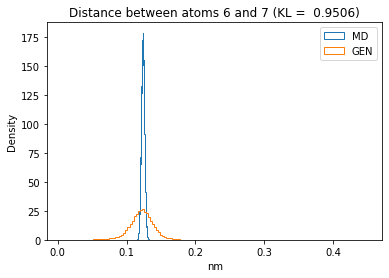

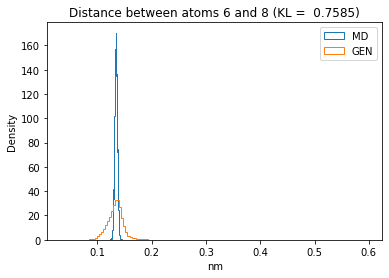

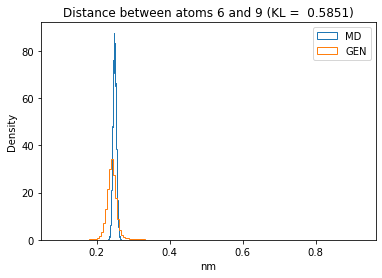

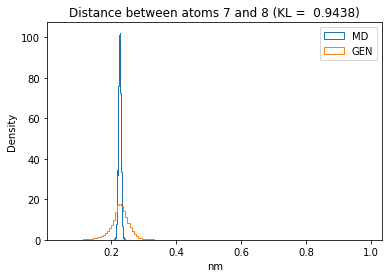

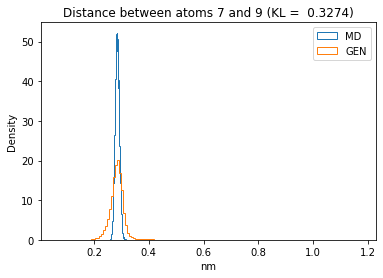

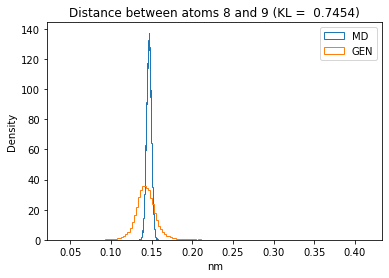

In [79]:
for i in range(n_atoms):
    for j in range(n_atoms):
        if i >= j:
            continue
        kl_i = score_kl_approximation(all_dmap[:,i,j], dmap_gen_eval[:,i,j])[0]
        plt.title("Distance between atoms %s and %s (KL =  %s)" % (
                  i, j, round(kl_i, 4)))
        plt.hist(all_dmap[:,i,j], histtype="step", bins=150, density=True, label="MD")
        plt.hist(dmap_gen_eval[:,i,j], histtype="step", bins=150, density=True, label="GEN")
        plt.xlabel("nm")
        plt.ylabel("Density")
        plt.legend()
        plt.show()

The let's take a look at the 3D conformations using `mdtraj` and `nglview`. Do they look kind of real to you?

In [80]:
m_traj_gen = mdtraj.Trajectory(xyz=x_gen_eval,
                               topology=heavyatom_topology)

if has_nglview:
    m_view_gen = nv.show_mdtraj(m_traj_gen)
    m_view_gen.center()
else:
    m_view_gen = None
m_view_gen

NGLWidget(max_frame=49999)

Finally, let's plot the Ramachandran plot for our generated ensemble. Does it bear some resemblance to the one observed in MD data? What are the most important differences? Is our GAN capturing all the metastable states in the system?

- Generated Ramachandran plot


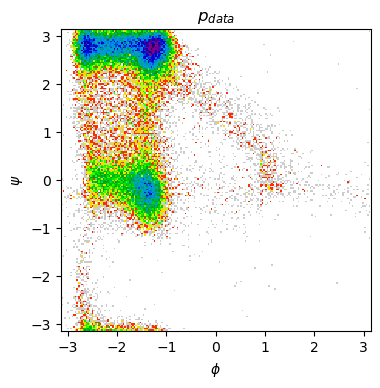


- MD Ramachandran plot


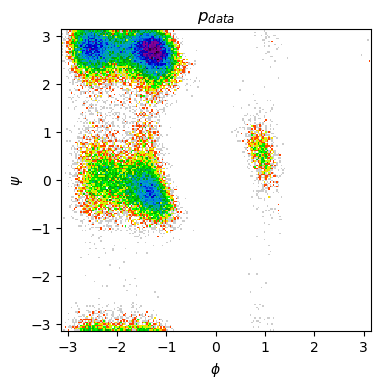

In [45]:
print("- Generated Ramachandran plot")
show_ramachandran_plot(m_traj_gen)

print("\n- MD Ramachandran plot")
show_ramachandran_plot(m_traj)

# Conclusions

Congratulations! You have modeled the your first conformational ensemble of a molecule with a generative model!

Please take a moment to pause and discuss what are in your opinion the strenghts and weaknesses that you found for this method.

Unfortunately, machine learning is highly dependant on the training data. You can get a feeling of this be running again this notebook and using only a selected part of the MD data. Instead of using 50000 random conformations, we will use the first 50000 conformations in the MD data: the simulation from which this data comes from, only sampled part of the conformational ensemble of the alanine dipeptide.

You can select this data by restarting the notebook and substituting the line `all_xyz = all_xyz[random_ids]` with `all_xyz = all_xyz[:20000]`.

When you train the GAN only with this data, is it going to be able to generate conformations for all the conformational ensemble?